### environment
* non gpu
* deeplabcut==2.1.8.2
* tensorflow==1.14.0

### why use tensorflow 1.X?
TensorFlow 2.x deprecates tf.contrib module, but DeepLabCut uses tf.contrib module.  
If tensorflow 2.X is installed in your development environment, it is recommended to work in a virtual environment. (For example, using the virtualenv package)

# 0. install packages

In [1]:
# !pip install numpy==1.16.4
# !pip install tensorflow==1.14
# !pip install deeplabcut==2.1.8.2

# 1. import packages

In [2]:
import numpy as np
import tensorflow as tf
np.__version__, tf.__version__

('1.16.4', '1.14.0')

In [3]:
import os
os.environ["DLClight"]="True"
HOME = os.path.expanduser('~')

import deeplabcut
from deeplabcut import pose_estimation_tensorflow as dlc
deeplabcut.__version__

DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


'2.1.8.2'

In [4]:
import yaml
import urllib
import tarfile

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

# 2. download full_dog model
Model 'full_dog' is pre-trained dog network created in DeepLabCut.

In [6]:
path_url_file = os.path.dirname(deeplabcut.__file__)+"/pose_estimation_tensorflow/models/pretrained/pretrained_model_urls.yaml"
with open(path_url_file) as f:
    url = yaml.load(f, Loader=yaml.FullLoader)

url = url['full_dog']
filename = url.split("/")[-1]

with open(filename, "wb") as f:
    r = urllib.request.urlopen(url)
    f.write(r.read())

In [7]:
ap = tarfile.open(filename)
ap.extractall('.')
ap.close

<bound method TarFile.close of <tarfile.TarFile object at 0x7faf2de1cf50>>

# 3. load session from downloaded model

In [8]:
path_cfg_file = './DLC_Dog_resnet_50_iteration-0_shuffle-0/pose_cfg.yaml'

In [9]:
with open(path_cfg_file) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

cfg['init_weights'] = os.getcwd()+'/DLC_Dog_resnet_50_iteration-0_shuffle-0/snapshot-75000'

with open(path_cfg_file, 'w') as f:
    yaml.dump(cfg, f)

In [10]:
yaml_cfg = dlc.config.cfg_from_file(path_cfg_file)
sess, inputs, outputs = dlc.nnet.predict.setup_pose_prediction(yaml_cfg)

Initializing ResNet


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /Users/zxcv/Documents/Workspace/Git/urillbwa-1/jupyter/hjj/DLC_Dog_resnet_50_iteration-0_shuffle-0/snapshot-75000


INFO:tensorflow:Restoring parameters from /Users/zxcv/Documents/Workspace/Git/urillbwa-1/jupyter/hjj/DLC_Dog_resnet_50_iteration-0_shuffle-0/snapshot-75000


In [11]:
print('sess -', sess)
print('inputs -', inputs)
print('outputs -', outputs)

sess - <tensorflow.python.client.session.Session object at 0x7faf2d3a5f50>
inputs - Tensor("Placeholder:0", shape=(?, ?, ?, 3), dtype=float32)
outputs - [<tf.Tensor 'Sigmoid:0' shape=(?, ?, ?, 20) dtype=float32>, <tf.Tensor 'pose/locref_pred/block4/BiasAdd:0' shape=(?, ?, ?, 40) dtype=float32>]


# 4. predict using session

### 1. load image for prediction

In [12]:
from PIL import Image

(726, 1210, 3)


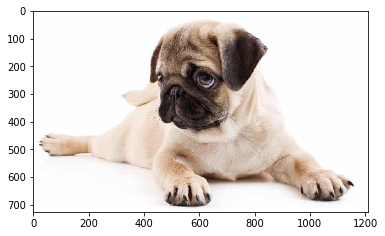

In [13]:
image_path = './test_image/1.jpg'
image_pil = Image.open(image_path)
predict_image = np.array(image_pil)
print(predict_image.shape)

plt.imshow(predict_image)
plt.show()

### 2. predict
Same as the code below  
```pose = dlc.nnet.predict.getpose(predict_image, cfg, sess, inputs, outputs, outall=False)```

In [14]:
%%time
result = sess.run(
    outputs, 
    feed_dict={inputs: np.expand_dims(predict_image, axis=0).astype(float)}
)

CPU times: user 6.78 s, sys: 717 ms, total: 7.49 s
Wall time: 1.09 s


In [15]:
print(result)

[array([[[[1.4215708e-05, 2.0951033e-05, 7.3015690e-06, ...,
          1.8477440e-05, 1.5944242e-05, 1.5735626e-05],
         [1.4603138e-06, 5.6624413e-07, 5.6624413e-07, ...,
          1.6391277e-06, 1.4901161e-06, 9.2387199e-07],
         [5.6624413e-07, 1.1920929e-07, 2.0861626e-07, ...,
          6.5565109e-07, 9.5367432e-07, 2.3841858e-07],
         ...,
         [2.2590160e-05, 4.7683716e-06, 2.5629997e-06, ...,
          1.8805265e-05, 7.7188015e-06, 6.7353249e-06],
         [9.0003014e-06, 1.3709068e-06, 7.7486038e-07, ...,
          4.7087669e-06, 4.1723251e-06, 2.8312206e-06],
         [1.6093254e-05, 4.4703484e-06, 1.9669533e-06, ...,
          2.4467707e-05, 9.9539757e-06, 9.1195107e-06]],

        [[4.7683716e-07, 4.4703484e-07, 1.4901161e-07, ...,
          4.4703484e-07, 8.9406967e-07, 1.0132790e-06],
         [5.9604645e-08, 0.0000000e+00, 5.9604645e-08, ...,
          2.9802322e-08, 2.6822090e-07, 8.9406967e-08],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 

In [16]:
cfg = dlc.config.load_config(path_cfg_file)
scmap, locref = dlc.nnet.predict.extract_cnn_output(result, cfg)
num_outputs = cfg.get("num_outputs", 1)
pose = dlc.nnet.predict.multi_pose_predict(scmap, locref, cfg.stride, num_outputs)
pose.shape

(20, 3)

In [17]:
# labeling
bodyparts = [
    'Nose',
    'L_Eye',
    'R_Eye',
    'L_Ear',
    'R_Ear',
    'Throat',
    'Withers',
    'TailSet',
    'L_F_Paw',
    'R_F_Paw',
    'L_F_Wrist',
    'R_F_Wrist',
    'L_F_Elbow',
    'R_F_Elbow',
    'L_B_Paw',
    'R_B_Paw',
    'L_B_Hock',
    'R_B_Hock',
    'L_B_Stiffle',
    'R_B_Stiffle'
]

In [18]:
# print '[x coordinate, y coordinate, likelihood], bodyparts'
for index in range(len(bodyparts)):
    print(pose[index], bodyparts[index])

[519.04553    300.76486      0.94436324] Nose
[623.0466    247.82462     0.9954307] L_Eye
[459.8442     243.91832      0.99605316] R_Eye
[770.198     129.06361     0.8274021] L_Ear
[439.67017   163.83852     0.6317637] R_Ear
[597.50464    468.98615      0.74920714] Throat
[379.85797    349.85864      0.58668405] Withers
[8.4027478e+02 1.3914767e+02 1.4771923e-01] TailSet
[1.1059996e+03 6.3272705e+02 8.0982411e-01] L_F_Paw
[ 66.82627    480.10666      0.65555996] R_F_Paw
[9.8341211e+02 5.6771979e+02 3.8547593e-01] L_F_Wrist
[5.3770746e+02 5.7334650e+02 3.7163591e-01] R_F_Wrist
[7.2140680e+02 5.6222235e+02 2.7363804e-01] L_F_Elbow
[4.4882632e+02 5.4807660e+02 2.8873056e-01] R_F_Elbow
[3.3013641e+02 5.4654590e+02 1.1202961e-01] L_B_Paw
[3.2985501e+02 5.4718555e+02 2.2773910e-01] R_B_Paw
[7.2379013e+01 5.1681683e+02 1.1064827e-02] L_B_Hock
[3.2303650e+02 5.2894867e+02 3.6934018e-02] R_B_Hock
[9.2150220e+02 5.6127240e+02 5.0828308e-02] L_B_Stiffle
[2.9613336e+02 5.0239584e+02 2.0901141e-01]

### 3. draw pose on image

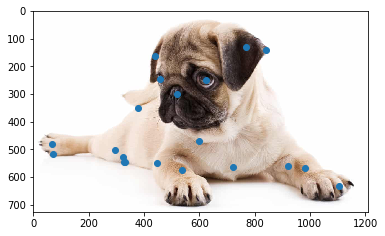

In [19]:
plt_x = pose[:, 0]
plt_y = pose[:, 1]
plt.imshow(predict_image)
plt.scatter(plt_x, plt_y)
plt.show()

# 5. save model

In [20]:
tf.saved_model.simple_save(
    sess,
    export_dir='./saved_model/',
    inputs={'Placeholder': inputs},
    outputs={'Sigmoid': outputs[0], 'pose/locref_pred/block4/BiasAdd': outputs[1]}
)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: ./saved_model/saved_model.pb


INFO:tensorflow:SavedModel written to: ./saved_model/saved_model.pb
